In [1]:
import os

curr_folder = os.getcwd() + "/"
datasets_folder = curr_folder[:-6] + "Datasets/"
stats_results_folder = curr_folder + "Results/"
print(datasets_folder)
print(stats_results_folder)

/home/ipsilva/Repositories/dynamic-projections/Datasets/
/home/ipsilva/Repositories/dynamic-projections/Stats/Results/


In [2]:
datasets_subfolders = []
for i in os.walk(datasets_folder):
    datasets_subfolders.append(i[0])

datasets_subfolders = datasets_subfolders[1:]
datasets_subfolders

['/home/ipsilva/Repositories/dynamic-projections/Datasets/gaussians',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/quickdraw',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/sorts',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/walk',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/nnset',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/fashion',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/cifar10cnn',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/esc50',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/qtables',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/cartolastd']

In [3]:
dataset_number = 5
selected_dataset = datasets_subfolders[dataset_number]
selected_dataset

'/home/ipsilva/Repositories/dynamic-projections/Datasets/fashion'

In [4]:
from os import listdir
from os.path import isfile, join

files = [f for f in listdir(selected_dataset) if isfile(join(selected_dataset, f))]
files[:5]

['tshirt-787-0.png',
 'bag-258-1.png',
 'trouser-450-8.png',
 'trouser-426-3.png',
 'sandal-416-2.png']

In [5]:
from sklearn.preprocessing import normalize
from itertools import product
import pandas as pd
import numpy as np
import cv2
import re

images_as_lines = []

obs_per_timestep = {}
for file in files:
    file_loc = selected_dataset + "/" + file
    image = cv2.imread(file_loc)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    line = gray.reshape(-1)
#     line = normalize(gray, axis=0, norm='max').reshape(-1)
    images_as_lines.append(line)
    
    time = re.search("[0-9]+.png$", file).group()
    try:
        obs_per_timestep[time] == False
        obs_per_timestep[time] += 1
    except:
        obs_per_timestep[time] = 1

obs_per_timestep = list(obs_per_timestep.values())
median_obs_per_timestep = np.median(obs_per_timestep)
dev_obs_per_timestep = np.std(obs_per_timestep)

(i,j) = gray.shape
i_l = [i_e for i_e in range(i)]
j_l = [j_e for j_e in range(j)]
columns = list(product(i_l, j_l))        
df = pd.DataFrame(images_as_lines, columns=columns)
print(df.shape, df.head())

(10000, 784)    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (0, 4)  (0, 5)  (0, 6)  (0, 7)  (0, 8)  \
0       2       0      51       0      66       0       0      99       0   
1      15       0       0       0      41      64     128       0       0   
2      17      24       6       0       0       8      13       0       0   
3       0      66       5       0      23       7      94      44       0   
4       5      12      58      22      56      22       0     103       0   

   (0, 9)  ...  (27, 18)  (27, 19)  (27, 20)  (27, 21)  (27, 22)  (27, 23)  \
0      80  ...        17         0         0       201       116        33   
1      51  ...         0         0         0         0       101        68   
2       0  ...         0         0         0         0         7         0   
3     255  ...        42         0         0        31       128         0   
4      69  ...       223         5         0        45         0         0   

   (27, 24)  (27, 25)  (27, 26)  (27, 27)  
0        14

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def intrisic_dim(dataframe, target_variance):
    dataframe = StandardScaler().fit_transform(dataframe)
    pca = PCA()

    principalComponents = pca.fit_transform(dataframe)

    list_variance = pca.explained_variance_ratio_

    final_var = 0
    dims = 0
    for var in list_variance:
        final_var += var
        dims += 1
        if final_var > target_variance:
            break
    return dims, final_var, principalComponents[:dims]

In [7]:
target_variance = 0.9

(dims, final_var, components) = intrisic_dim(df, target_variance)

print("Total time-steps:", len(obs_per_timestep))
print("Registers per time-step (median):", median_obs_per_timestep)
print("Registers per time-step (deviation):", dev_obs_per_timestep)
print("Total dimensions:", df.shape[1])
print("Intrinsic dimensions:", dims)
print("Total variance:", final_var)

Total time-steps: 10
Registers per time-step (median): 1000.0
Registers per time-step (deviation): 0.0
Total dimensions: 784
Intrinsic dimensions: 502
Total variance: 0.9004330683058499


In [10]:
fig_name = selected_dataset.split('/')[-1]

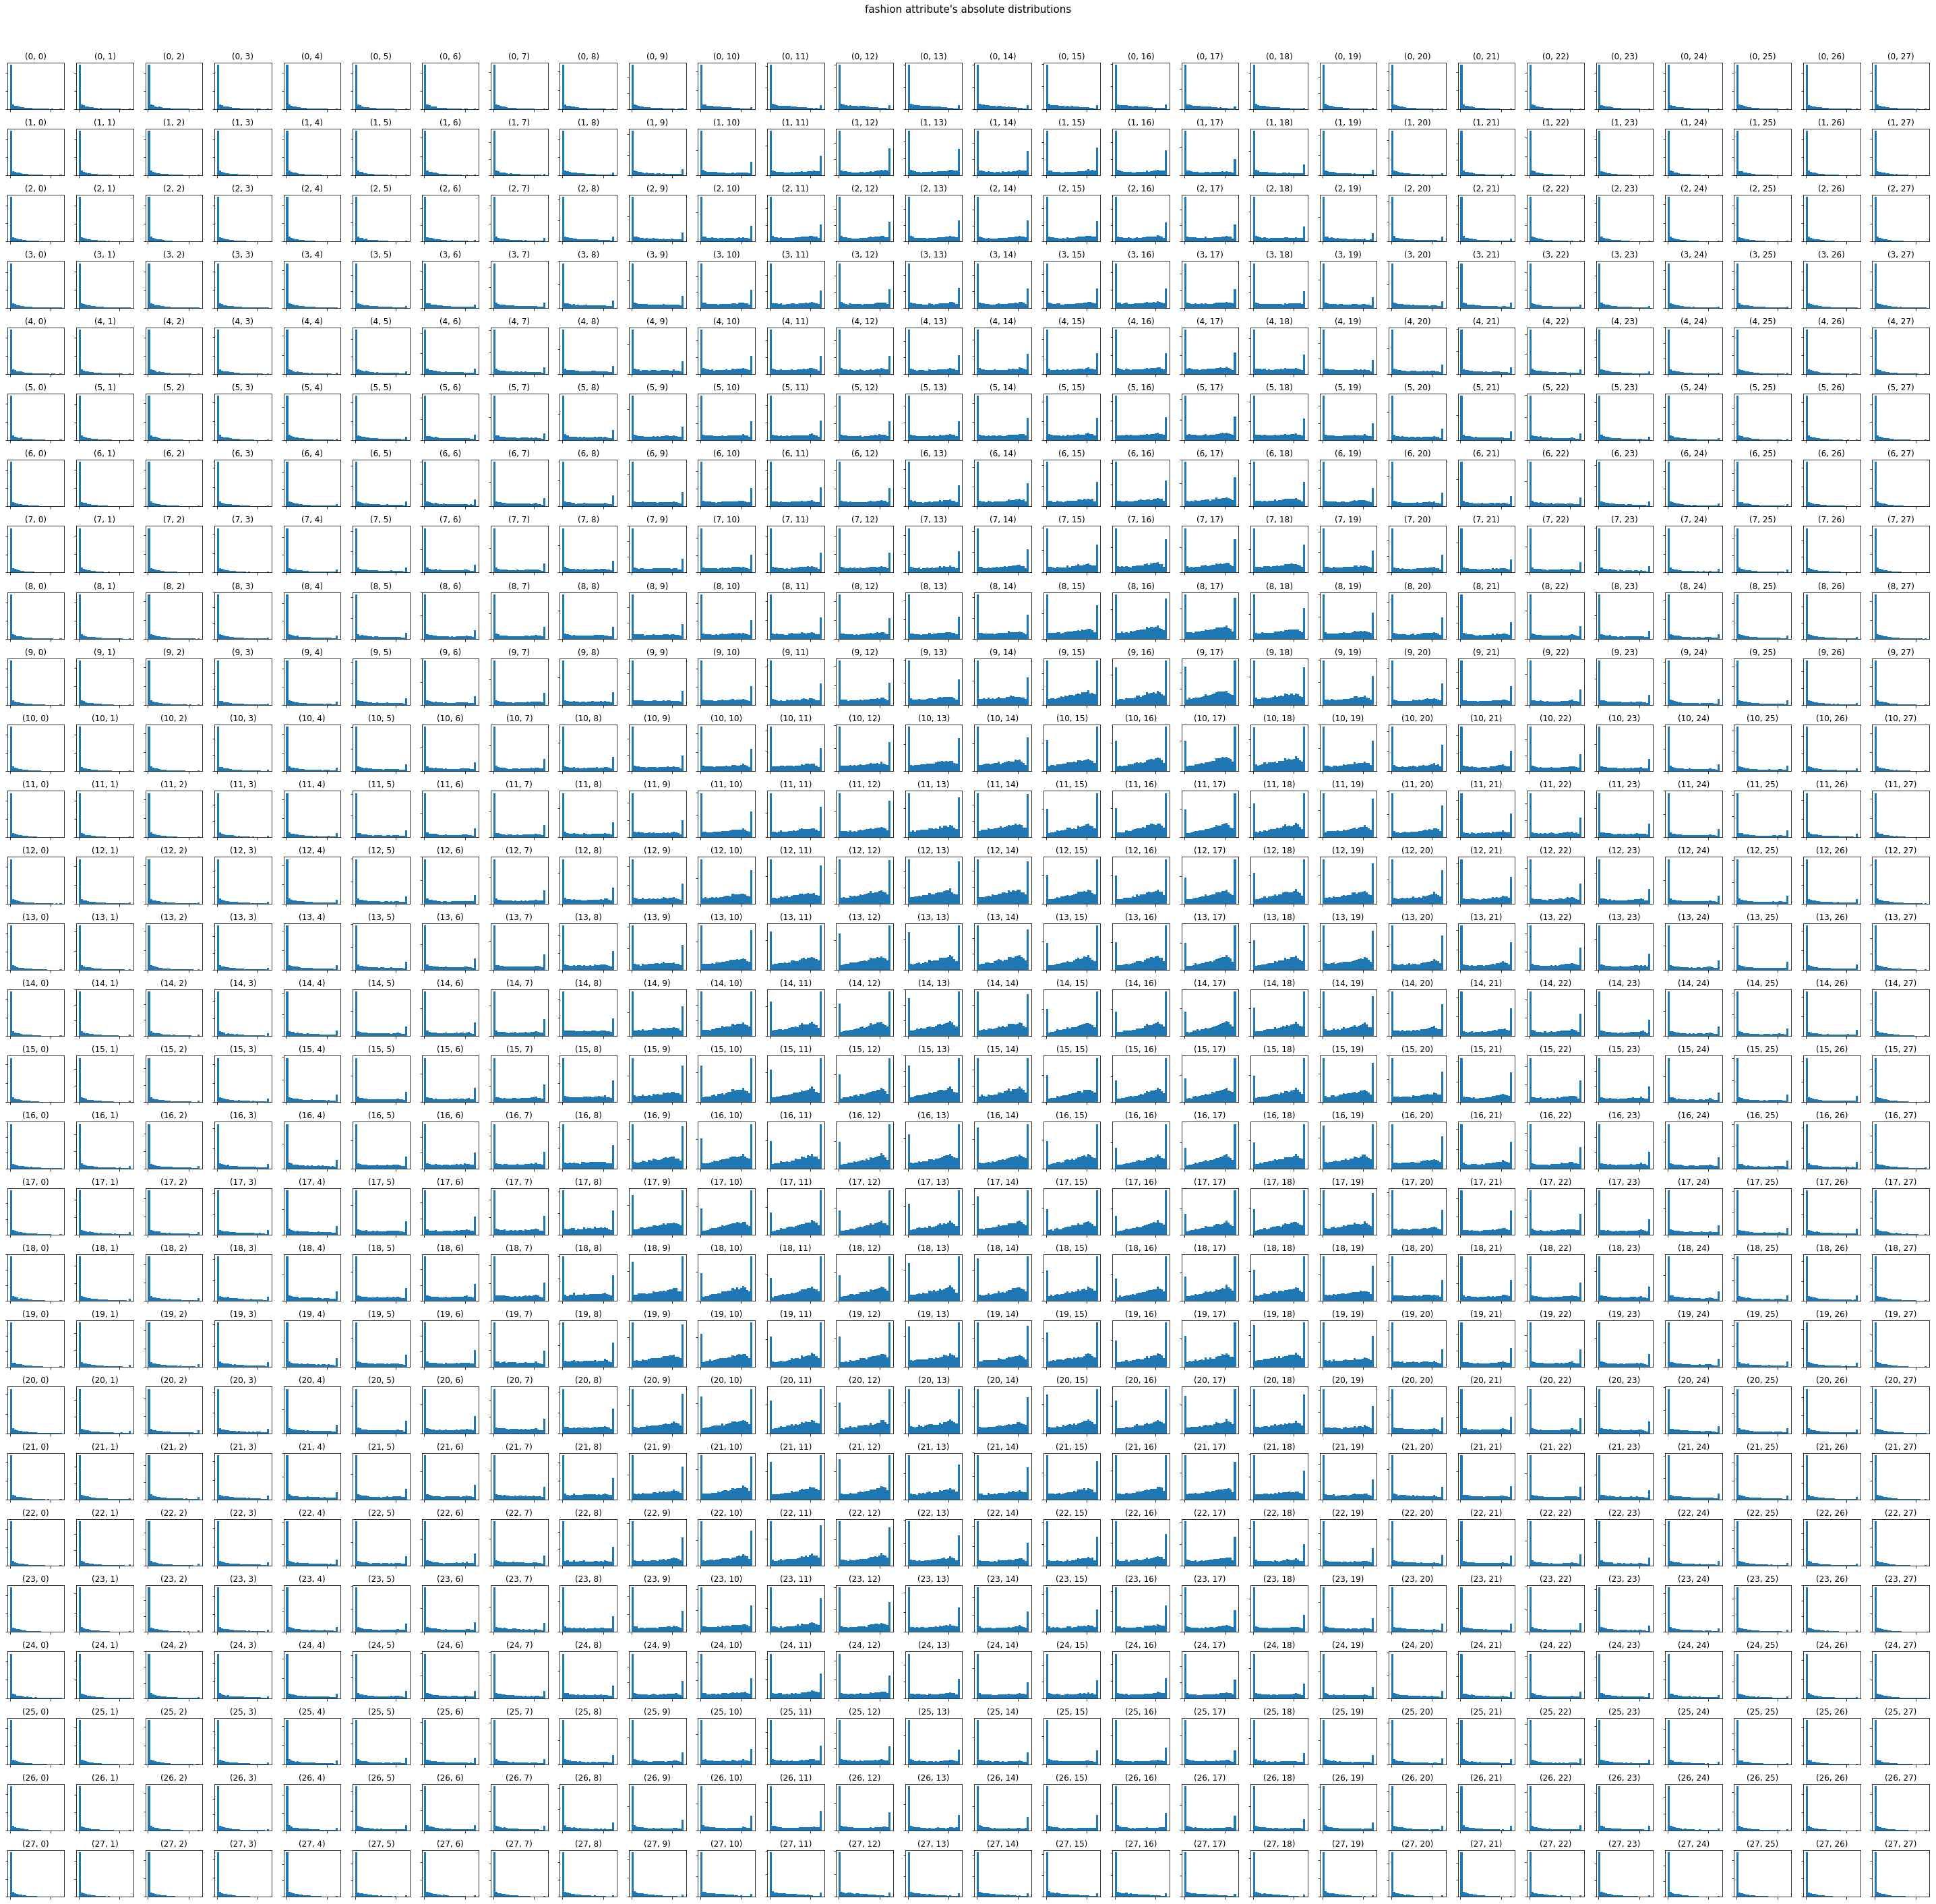

In [24]:
import matplotlib.pyplot as plt

# identifying distributions
hists_ax = df.hist(bins=25, grid=False, figsize=(40,40), density=True)

for arr in hists_ax:
    for ax in arr:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
plt.suptitle(fig_name + " attribute's absolute distributions", fontsize=15, weight='roman')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(stats_results_folder+"attribute_histograms/"+fig_name+"_attr_dist")

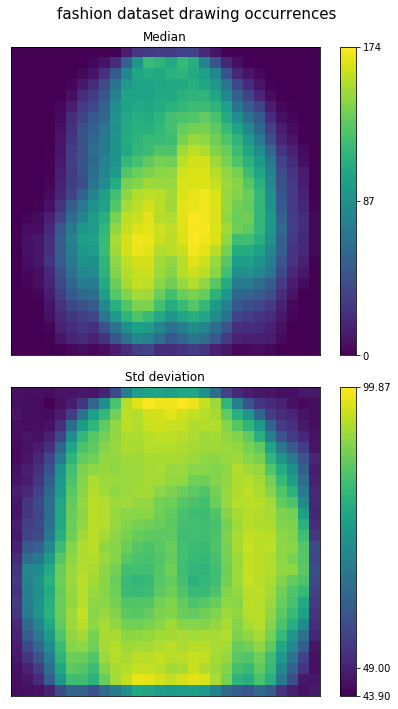

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,10))
im_med = ax[0].imshow(df.median().values.reshape(28,28), interpolation='none')
im_std = ax[1].imshow(df.std().values.reshape(28,28), interpolation='none')

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

cbar_med = ax[0].figure.colorbar(im_med, ax=ax[0], ticks=[min(df.median().values), int(max(df.median().values)/2.0), max(df.median().values)])
# cbar_med.set_ylabel("Std dev", rotation=-90, va="bottom")

cbar_std = ax[1].figure.colorbar(im_std, ax=ax[1], ticks=[min(df.std().values), int(max(df.std().values)/2.0), max(df.std().values)])
# cbar_std.ax[1].set_ylabel("Std dev", rotation=-90, va="bottom")

ax[0].set_title("Median")
ax[1].set_title("Std deviation")

plt.suptitle(fig_name + " dataset drawing occurrences", fontsize=15, weight='roman')
plt.tight_layout()
plt.subplots_adjust(top=0.925)

plt.savefig(stats_results_folder+"image_dss_heatmaps/"+fig_name+"_drawing_heatmap")